In [114]:
# Importujeme si opět knihovny jako minule
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

from keras import layers
# %matplotlib ipympl

TensorFlow version: 2.16.2
Keras version: 3.5.0


# Klasifikace koček a psů
- Cvičení je vypracováno na základě knihy Deep Learning with Python a [Keras Image classification example](https://keras.io/examples/vision/image_classification_from_scratch/).
- Budeme pracovat s datasetem: https://www.kaggle.com/c/dogs-vs-cats/data.
    - V Keras tutoriálu je přímo návod jak dataset stáhnout.
    - Stažení přes Kaggle: musíte si ověřit účet na Kaggle a přihlásit se do soutěže pro stáhnutí datasetu
- Dataset obsahuje velmi mnoho obrázků pro klasifikaci. My použijeme pouze část, abychom simulovali chování na menším datasetu.
- Data si rozbalte a přesuňte do složky, kde máte tento notebook
- Přiložil jsem proto soubor subset.py, který nám pomůže data zredukovat a vytvořit příslušné složky
- V případě, že nechcete použít tento soubor, můžete si data zredukovat ručně podle požadovaného formátu: typ_dat/třída/x.jpg

- Pro zájemce se doporučuji podívat [KerasCV](https://keras.io/keras_cv/)

In [115]:
# https://keras.io/api/data_loading/image/
from keras.utils import image_dataset_from_directory
batch_size = 128

# Vytvoříme si generátor obrázků, který nám bude postupně dodávat data
train_dataset = image_dataset_from_directory(
    "train_subset",
    image_size=(150, 150),  # Velikost obrázků
    batch_size=batch_size,
    label_mode="binary",    # Podle typu labels
)
# Výstupem jsou: (data, labels) 
# Data: (128, 150, 150, 3) - 20 obrázků o velikosti 150x150 pixelů a 3 barevnými kanály
# Label: (128, 1) - 20 labelů (0/1)

validation_dataset = image_dataset_from_directory(
    "validation_subset",
    image_size=(150, 150),  # Velikost obrázků
    batch_size=batch_size,
    label_mode="binary",    # Podle typu labels
)

test_dataset = image_dataset_from_directory(
    "test_subset",
    image_size=(150, 150),  # Velikost obrázků
    batch_size=batch_size,
    label_mode="binary",    # Podle typu labels
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


2024-10-20 17:01:45.110593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


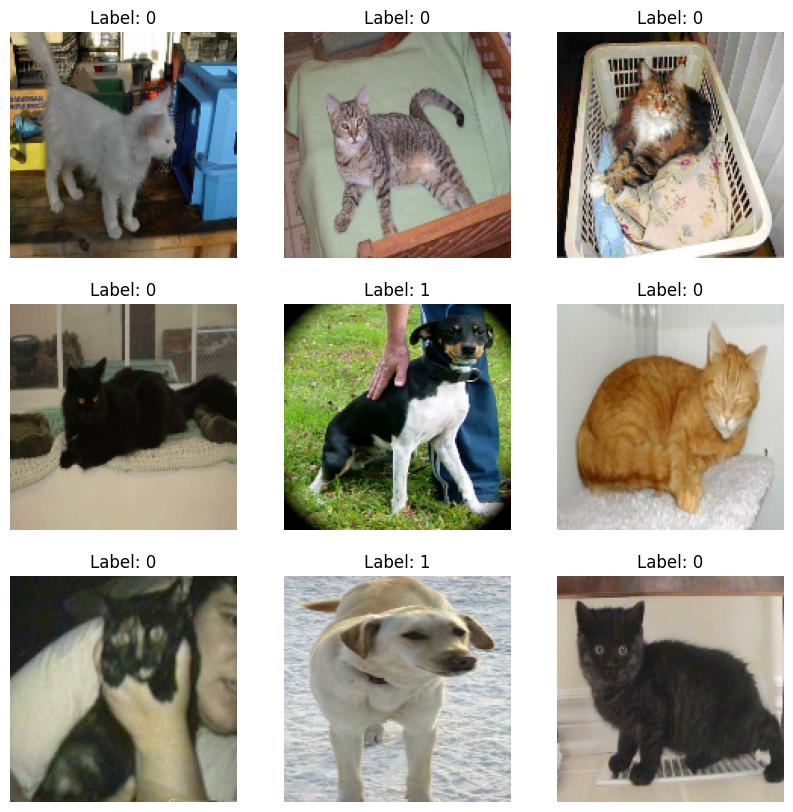

In [116]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")

## Data augmentation
- **data augmentation** je technika zabývající se, generováním dat na základě dat, které už máme
	- jednoduchým příkladem může být například: upravení jasu obrázku, otočení, atd.
- cílem je přidat více dat pro testování, čímž obecně zlepšíme generalizaci
- V knihovně Keras jsou přímo dostupné metody pro úpravu ([zde](https://keras.io/api/keras_cv/layers/augmentation/))
	- Další možnost je využít knihovnu [Albumentations](https://albumentations.ai/)
- Více informací: [IBM](https://www.ibm.com/topics/data-augmentation), [Amazon](https://aws.amazon.com/what-is/data-augmentation/)

2024-10-20 17:01:45.593939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


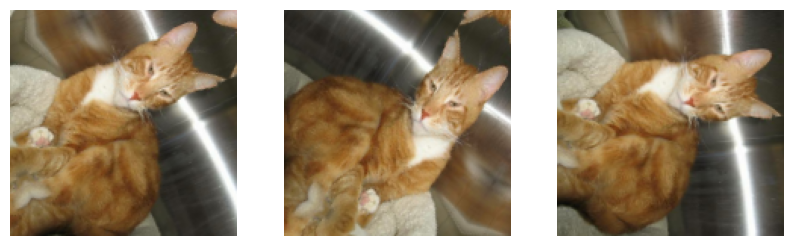

In [117]:
# Úkázka úpravy obrázků

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    first_image = images[0]
    for i in range(3):
        # Provedeme úpravu obrázku
        augmented_image = layers.RandomFlip("horizontal")(first_image)
        augmented_image = layers.RandomRotation(0.25)(augmented_image)

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_image).astype("uint8"))
        plt.axis("off")

In [118]:
# Vytvoříme si šablonu toho, jak budeme upravovat data
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.25),
    layers.Rescaling(1.0 / 255), # Stejně jako u MNIST příkladu upravíme hodnoty pixelů na rozsah 0-1
]

# Podle šablony upravíme obrázky
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [119]:
# Taková úprava dat bude probíhat asynchronně na procesoru a před vstupem do modelu bude uloženo do vyrovnávací paměti.
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x), y)
)

validation_dataset = validation_dataset.map(
    lambda x, y: (x / 255.0, y)
)

test_dataset = test_dataset.map(
    lambda x, y: (x / 255.0, y)
)

# Alternativně bychom mohli vrstvy na úpravu vložit přímo do modelu. Tím pádem by byl výpočet synchroní na GPU.
# pozn. rozšiřování dat je v době testování – tj. při volání funkce evaluate() nebo predict() – neaktivní, takže data budou upraveny pouze během funkce fit()

In [120]:
model = keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['acc']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [121]:
trained = model.fit(
    train_dataset,
    epochs=30, # Pokud nechcete dlouho čekat, tak doporučuji nastavit na 15 epoch.
    validation_data=validation_dataset,
)
# Zhruba 17 minut učení. (Apple M1)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.4863 - loss: 0.7574 - val_acc: 0.5000 - val_loss: 0.6886
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.5301 - loss: 0.6881 - val_acc: 0.5090 - val_loss: 0.6995
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.5190 - loss: 0.6850 - val_acc: 0.5850 - val_loss: 0.6698
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - acc: 0.5513 - loss: 0.6790 - val_acc: 0.5770 - val_loss: 0.6639
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - acc: 0.5912 - loss: 0.6628 - val_acc: 0.6270 - val_loss: 0.6598
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - acc: 0.6009 - loss: 0.6571 - val_acc: 0.6190 - val_loss: 0.6371
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - acc: 0.6200 - loss: 0.6475 - val_acc: 0.6460 - val_loss: 0.6314
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - acc: 0.6658 - loss: 0.6163 - val_acc: 0.6710 - val_loss: 0.5839
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - acc: 0.6705 - loss: 

acc         0.779500
loss        0.465451
val_acc     0.743000
val_loss    0.550232
Name: 29, dtype: float64

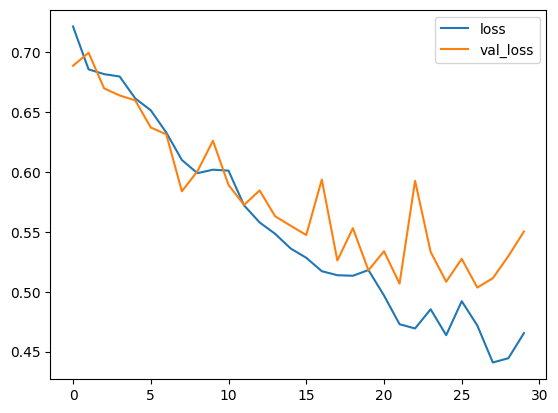

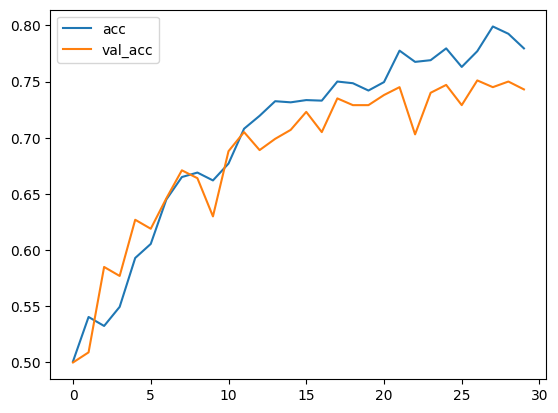

In [122]:
history = pd.DataFrame(trained.history)

history.loc[:, ['loss', 'val_loss']].plot()
history.loc[:, ['acc', 'val_acc']].plot()

# V poslední epoše.
history.iloc[-1]

# Přesnost na validačních datech se drží kolem 74%.
# Při delším trénování by se přesnost nejspíš mohla zvýšit. Záleží na overfittingu.

In [123]:
score = model.evaluate(test_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5813367962837219
Test accuracy: 0.7179999947547913


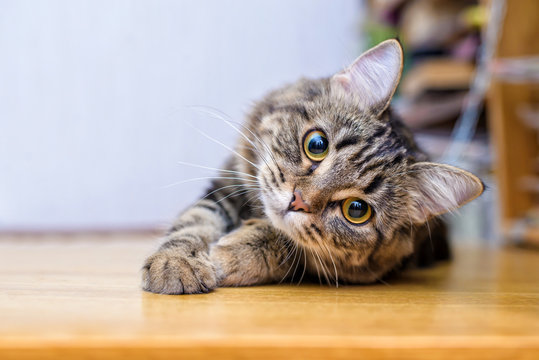

In [137]:
from PIL import Image
import requests

img_url = "https://t3.ftcdn.net/jpg/02/36/99/22/360_F_236992283_sNOxCVQeFLd5pdqaKGh8DRGMZy7P4XKm.jpg"
img = Image.open(requests.get(img_url, stream=True).raw)
img

In [138]:
# Preprocessing obrázku
img_augmented = img.resize((150, 150))
img_augmented = np.array(img_augmented).astype("uint8")
print(f"Before: {img_augmented.shape}")
img_augmented = np.expand_dims(img_augmented, 0)
print(f"After: {img_augmented.shape}")
img_augmented = img_augmented / 255.0

Before: (150, 150, 3)
After: (1, 150, 150, 3)


In [139]:
predictions = model.predict(img_augmented)
score = predictions[0][0]
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This image is 96.01% cat and 3.99% dog.


## Transfer learning 
- je technika při které se znalosti získané v rámci jedné úlohy používají ke zlepšení výkonnosti modelu v jiné související úloze
    - konkrétně to může probíhat tak, že místo tvorby a trénování kompletně nového modelu se využije model (nebo část modelu) předem natrénovaný a vyladí se pro požadovaná data
- předtrénované modely jsou natrénovány nad obrovským množstvím dat (i přes milión obrázků – [ImageNet](https://paperswithcode.com/dataset/imagenet)) a dokáží klasifikovat velké množství tříd
- výhody: 
    - časově úspornější – trénování nového modelu je vyžaduje velké množství dat a výpočetní výkon
    - generalizace je obecně lepší
- jsou dva typy Transfer learning:
    - **Feature extraction**
        - v případě CNN se vezme **convolutional base** předtrénovaného modelu a naučíme nový **klasifikátor** na základě našich vstupů
    - **Fine-tuning**
        - v tomto případě kromě **klasifikátoru** trénujeme i část **convolutional base**
            - proč? tyto vrstvy obsahují vyšší míru abstrakce a jejich natrénování způsobí přizpůsobení modelu našim datům
- proč to můžeme využít?
    - reprezentace naučené pomocí **convolutional base** jsou obecnější, protože se učí rysy nad obrázky s ohledem na prostorovost
    - reprezentace u **klasifikátorů** jsou specifické pro trénovací množinu a nemají informace o prostoru obrázku
- seznam předtrénovaných modelů v Keras [zde](https://keras.io/api/applications/)

- Vyzkoušejte si sami: [Keras Guide – Transfer learning](https://keras.io/guides/transfer_learning/), [TensorFlow Guide – Transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning) 
- Zdroje: [Amazon – Transfer learning](https://aws.amazon.com/what-is/transfer-learning/), [IBM – Transfer learning](https://www.ibm.com/topics/transfer-learning), Kniha Deep Learning with Python

<img src="https://www.researchgate.net/publication/344197871/figure/fig5/AS:934418801778698@1599794211953/Fixed-feature-extraction-and-fine-tuning-method-of-transfer-learning-56.ppm" style="background-color:white;padding: 1rem" />

In [127]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Načteme předtrénované váhy nad datasetem ImageNet.
    input_shape=(150, 150, 3),
    include_top=False, # Obsáhnutí klasifikátoru z ImageNet
)

# Zmrazíme model, ať se nemění jeho váhy.
base_model.trainable = False

In [128]:
inputs = layers.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_18 (InputLayer) │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_7  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_7 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_11 (Dense)            │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [144]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['acc']
)

In [145]:
trained = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - acc: 0.8959 - loss: 0.2475 - val_acc: 0.9650 - val_loss: 0.1053
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - acc: 0.8917 - loss: 0.2432 - val_acc: 0.9620 - val_loss: 0.1024
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - acc: 0.9083 - loss: 0.2186 - val_acc: 0.9670 - val_loss: 0.0948
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - acc: 0.9017 - loss: 0.2035 - val_acc: 0.9650 - val_loss: 0.0893
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - acc: 0.9021 - loss: 0.2199 - val_acc: 0.9680 - val_loss: 0.0863


acc         0.910500
loss        0.207416
val_acc     0.968000
val_loss    0.086270
Name: 4, dtype: float64

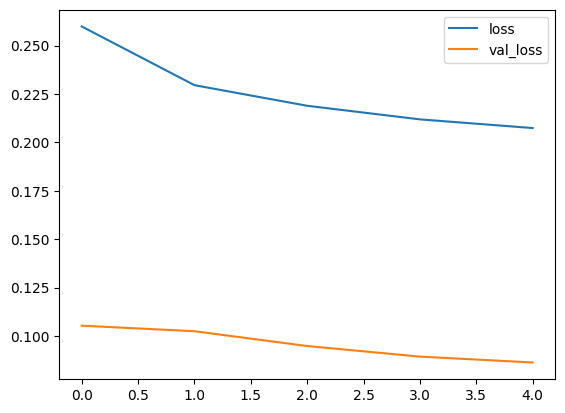

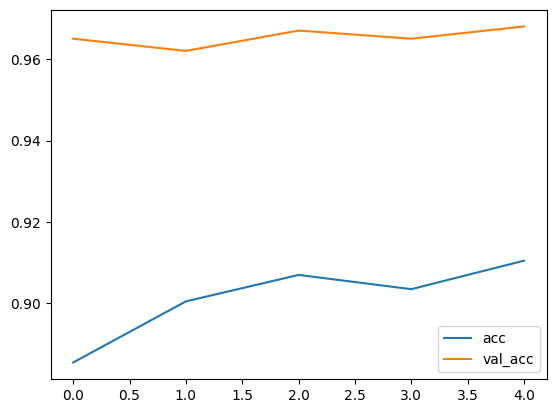

In [146]:
history = pd.DataFrame(trained.history)

history.loc[:, ['loss', 'val_loss']].plot()
history.loc[:, ['acc', 'val_acc']].plot()

# V poslední epoše.
history.iloc[-1]

In [149]:
score = model.evaluate(test_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08680091798305511
Test accuracy: 0.9679999947547913


In [148]:
predictions = model.predict(img_augmented)
score = predictions[0][0]
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
This image is 99.11% cat and 0.89% dog.
